# TP3 - Deep Learning : Méthodologie, Expérimentations et Régularisation 

<p style="font-weight: bold; font-size: 16px;"><span style="color: red;">Auteur : </span>TOURE Boubacar (<a href="boubacar.toure@etud.univ-angers.fr">boubacar.toure@etud.univ-angers.fr</a>), étudiant en Master 2 Informatique à la faculté des sciences d'Angers</p>
<p style="font-weight: bold; font-size: 16px;"><span style="color: red;">Professeur Référent : </span>Sylvain Lamprier (<a href="sylvain.lamprier@univ-angers.fr">sylvain.lamprier@univ-angers.fr</a>)</p>

Supports adaptés de Nicolas Baskiotis (<a href="nicolas.baskiotis@sorbonne-univeriste.fr">nicolas.baskiotis@sorbonne-univeriste.fr</a>) et Benjamin Piwowarski (<a href="benjamin.piwowarski@sorbonne-universite.fr">benjamin.piwowarski@sorbonne-universite.fr</a>) -- MLIA/ISIR, Sorbonne Université

# Import du projet

In [2]:
import matplotlib.pyplot as plt
import torch.nn as nn
import shutil
import torch
import time
import os

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm.autonotebook import tqdm
from tqdm import tqdm

# Déclaration des fonctions 

In [3]:
def save_state(fichier,epoch,model,optim):
    state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
    torch.save(state,fichier)

def load_state(fichier,model,optim):
    epoch = 0
    if os.path.isfile(fichier):
        state = torch.load(fichier)
        model.load_state_dict(state['model_state'])
        optim.load_state_dict(state['optim_state'])
        epoch = state['epoch']
    return epoch

def unnormalize(img, mean, std):
    if img.dim()==2 or ((img.dim()==3) and (img.size()[0]==1)):
        return img*std[0]+mean[0]
    return img * img.new(std).view(3, 1, 1) + img.new(mean).view(3, 1, 1)


def train(model, train_loader, validation_loader, loss_fn, optimizer, epochs, typeTrain=""):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train")
    
    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train-{typeTrain}.pth"
    
    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train")
    
    train_losses = []
    validation_losses = []
    accuraciesOfValidation = []
    accuraciesOfTrain = []

    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        accuracy = correct / total
        accuraciesOfTrain.append(accuracy)
        summary.add_scalar("Accuracy_Of_Train", accuracy, epoch)
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))
            
        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            save_state(check_file, epoch, model, optimizer)
            model.eval()
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            accuraciesOfValidation.append(accuracy)
            summary.add_scalar("Accuracy_Of_Validation", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))
            
            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(epoch, train_loss/len(train_loader), accuracy))
    end_time = time.time()
    
    trainTime = end_time - start_time
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfTrain)
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfValidation)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train
    
    return trainTime, trainModelComplexity, validation_loss, accuracy

def set_dropout_rate(m, rate):
    if type(m) == nn.Dropout:
        m.p = rate

def train_dropout(model, train_loader, validation_loader, loss_fn, optimizer, epochs, dropout_rate, typeTrain=""):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train_dropout"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train_dropout")
    
    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train_dropout-{typeTrain}.pth"
    
    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train_dropout")
    
    train_losses = []
    validation_losses = []
    accuraciesOfValidation = []
    accuraciesOfTrain = []
    
    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        model.apply(lambda x: set_dropout_rate(x, dropout_rate))
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        accuracy = correct / total
        accuraciesOfTrain.append(accuracy)
        summary.add_scalar("Accuracy_Of_Train", accuracy, epoch)
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))
            
        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            model.eval()
            model.apply(lambda x: set_dropout_rate(x, 0))
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            accuraciesOfValidation.append(accuracy)
            summary.add_scalar("Accuracy", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))
            
            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(epoch, train_loss/len(train_loader), accuracy))
    end_time = time.time()
    trainTime = end_time - start_time
    
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfTrain)
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfValidation)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train_dropout
    
    return trainTime, trainModelComplexity, validation_loss, accuracy

def train_batchnorm(model, train_loader, validation_loader, loss_fn, optimizer, epochs, typeTrain=""):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    # Clear any logs from previous runs
    if os.path.exists(f"/tmp/logs/deepLearning/{model.name}-train_batchnorm"):
        shutil.rmtree(f"/tmp/logs/deepLearning/{model.name}-train_batchnorm")

    # On créé un writer avec la date du modèle pour s'y retrouver
    TB_PATH = f"/tmp/logs/deepLearning"
    MODEL_PATH = "/tmp/models/"
    os.makedirs(MODEL_PATH, exist_ok=True)
    check_file = f"{MODEL_PATH}/{model.name}-train_batchnorm-{typeTrain}.pth"

    summary = SummaryWriter(f"{TB_PATH}/{model.name}-train_batchnorm")

    train_losses = []
    validation_losses = []
    accuraciesOfValidation = []
    accuraciesOfTrain = []

    start_epoch = load_state(check_file, model, optimizer)
    
    start_time = time.time()
    for epoch in range(start_epoch, epochs+1):
        # Entraînement sur les données d'entraînement
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        accuracy = correct / total
        accuraciesOfTrain.append(accuracy)
        summary.add_scalar("Accuracy_Of_Train", accuracy, epoch)
        summary.add_scalar("Loss_Of_Train", train_loss/len(train_loader), epoch)
        train_losses.append(train_loss/len(train_loader))

        if epoch % 10 == 0: 
            # Evaluation sur les données de test
            model.eval()
            with torch.no_grad():
                validation_loss = 0
                correct = 0
                total = 0
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    validation_loss += loss_fn(outputs, labels).item()
            
            accuracy = correct / total
            accuraciesOfValidation.append(accuracy)
            summary.add_scalar("Accuracy", accuracy, epoch)
            summary.add_scalar("Loss_Of_Validation", validation_loss/len(validation_loader), epoch)
            validation_losses.append(validation_loss/len(validation_loader))

            print("\tEpoch {}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(epoch, validation_loss, accuracy))
        else:
            print("Epoch {}, Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(epoch, train_loss/len(train_loader), accuracy))
    end_time = time.time()
    trainTime = end_time - start_time
    
    trainModelComplexity = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    plt.figure
    plt.plot(train_losses)
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfTrain)
    plt.title('Train Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(validation_losses)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(accuraciesOfValidation)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    # Load the TensorBoard notebook extension
    %load_ext tensorboard
    %tensorboard --logdir {TB_PATH}/{model.name}-train_batchnorm
    
    return trainTime, trainModelComplexity, validation_loss, accuracy


# requiert que les modules soient enregistrés dans une liste model.hidden_layers
def addWeightsHisto(writer, model, epoch):                
    ix = 0
    for module in model.hidden_layers:
        if isinstance(module, nn.Linear):
            writer.add_histogram(f'Linear/{ix}/weight', module.weight, epoch)
            ix += 1

# Déclaration des class

In [4]:
class LinearMultiClass(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClass, self).__init__()
        self.name = "Linear_Multi_Class"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.activation(x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

class LinearMultiClassWithDropout(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, dropout_rate=0.5, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClassWithDropout, self).__init__()
        self.name = "Linear_Multi_Class_With_Dropout"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        self.dropout_rate = dropout_rate
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))
            self.dropout_layers.append(nn.Dropout(p=self.dropout_rate))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.activation(x)
            x = self.dropout_layers[i](x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x

class LinearMultiClassWithBatchNorm(nn.Module):
    def __init__(self, in_size, out_size, hidden_layers, final_activation=None, activation=nn.Tanh()):
        super(LinearMultiClassWithBatchNorm, self).__init__()
        self.name = "Linear_Multi_Class_With_BatchNorm"
        self.in_size = in_size
        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()
        self.output_layer = nn.Linear(hidden_layers[-1], out_size)
        self.final_activation = final_activation
        self.activation = activation
        
        for i, h in enumerate(hidden_layers):
            self.hidden_layers.append(nn.Linear(in_size if i == 0 else hidden_layers[i-1], h))
            self.batch_norm_layers.append(nn.BatchNorm1d(h))

    def forward(self, x):
        x = x.view(-1, self.in_size)
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            x = self.batch_norm_layers[i](x)
            x = self.activation(x)

        x = self.output_layer(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x


# Déclaration des données du projet

In [5]:
#Transformations à appliquer sur le dataset (transformation des images en tenseurs et normalization pour obtenir des valeurs entre -1 et 1)
mean = [0.5]
std = [0.5]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Téléchargement des données (via le dataset specifique MNIST de pytorch)
mnist_train = MNIST('./data', train=True, transform=transform, download=True)
mnist_test = MNIST('./data', train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(mnist_test, batch_size=batch_size)

TB_PATH = f"/tmp/logs/deepLearning"
epoch = 100

in_size = 784
out_size = 10
hidden_layers = [100, 100, 100]

# Récuperation d'une image de notre batch de données

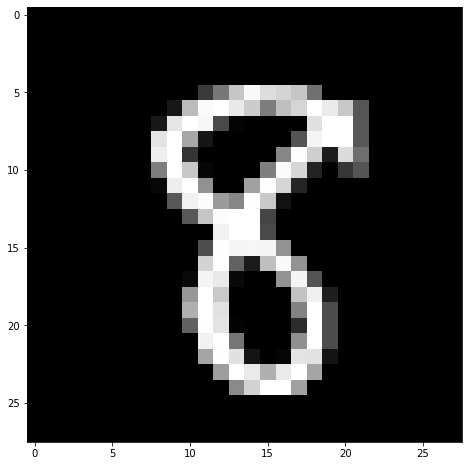

In [6]:
imgs,labs = next(iter(train_loader))

# dimension of images (flattened)reload_ext tensorboard
HEIGHT,WIDTH = imgs.shape[2], imgs.shape[3] # taille de l'image
INPUT_DIM = HEIGHT * WIDTH

#Visualisation de la première image
img = unnormalize(imgs[0], mean, std) # pour retrouver l'image d'origine (avant normalisation)
fig = plt.figure(figsize=(8, 8))

plt.imshow(img.squeeze(),cmap='Greys_r')

# Construction et Entrainement des modèles

## Modèle LinearMultiClass

### Avec activation = nn.Tanh

	Epoch 0, Validation Loss: 186.9433, Validation Accuracy: 0.7991
Epoch 1, Train Loss: 0.9444, Train Accuracy: 0.8276
Epoch 2, Train Loss: 0.6519, Train Accuracy: 0.8653
Epoch 3, Train Loss: 0.5155, Train Accuracy: 0.8827
Epoch 4, Train Loss: 0.4402, Train Accuracy: 0.8912
Epoch 5, Train Loss: 0.3934, Train Accuracy: 0.8982
Epoch 6, Train Loss: 0.3617, Train Accuracy: 0.9030
Epoch 7, Train Loss: 0.3388, Train Accuracy: 0.9073
Epoch 8, Train Loss: 0.3213, Train Accuracy: 0.9109
Epoch 9, Train Loss: 0.3069, Train Accuracy: 0.9136
	Epoch 10, Validation Loss: 44.2296, Validation Accuracy: 0.9208
Epoch 11, Train Loss: 0.2851, Train Accuracy: 0.9184
Epoch 12, Train Loss: 0.2761, Train Accuracy: 0.9207
Epoch 13, Train Loss: 0.2679, Train Accuracy: 0.9231
Epoch 14, Train Loss: 0.2605, Train Accuracy: 0.9248
Epoch 15, Train Loss: 0.2535, Train Accuracy: 0.9267
Epoch 16, Train Loss: 0.2472, Train Accuracy: 0.9282
Epoch 17, Train Loss: 0.2410, Train Accuracy: 0.9303
Epoch 18, Train Loss: 0.2352, T

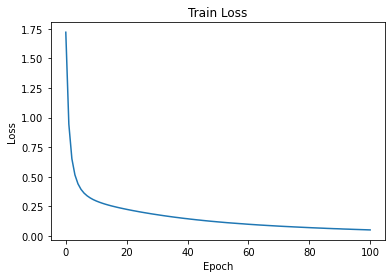

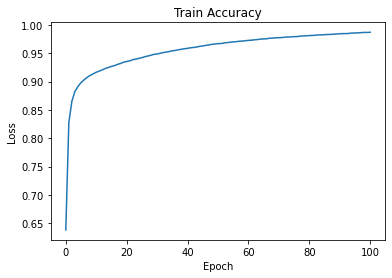

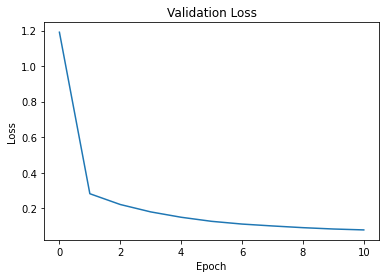

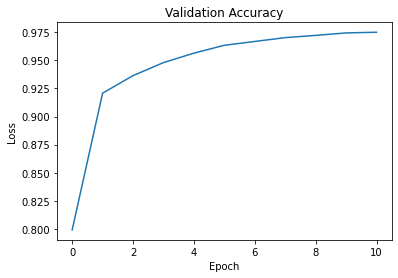

In [7]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.Tanh())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
model1ExecutionTimeTanhAdam, model1ComplexityTanhAdam, model1ValidationLossTanhAdam, model1AccuracyTanhAdam = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="Tanh-Adam")

	Epoch 90, Validation Loss: 294.7635, Validation Accuracy: 0.6573
Epoch 91, Train Loss: 1.8835, Train Accuracy: 0.6466
Epoch 92, Train Loss: 1.8784, Train Accuracy: 0.6481
Epoch 93, Train Loss: 1.8732, Train Accuracy: 0.6495
Epoch 94, Train Loss: 1.8680, Train Accuracy: 0.6506
Epoch 95, Train Loss: 1.8629, Train Accuracy: 0.6522
Epoch 96, Train Loss: 1.8577, Train Accuracy: 0.6536
Epoch 97, Train Loss: 1.8525, Train Accuracy: 0.6551
Epoch 98, Train Loss: 1.8473, Train Accuracy: 0.6564
Epoch 99, Train Loss: 1.8421, Train Accuracy: 0.6574
	Epoch 100, Validation Loss: 286.4953, Validation Accuracy: 0.6704


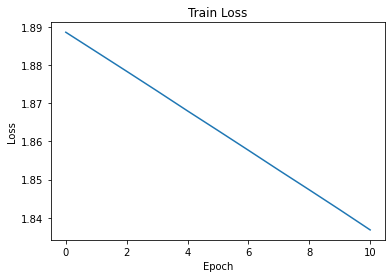

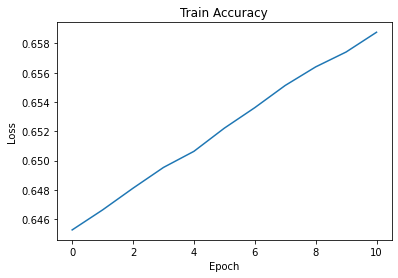

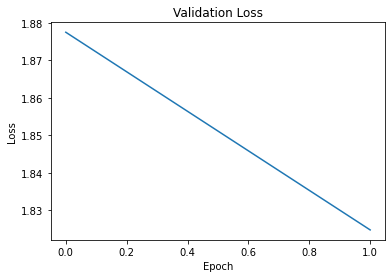

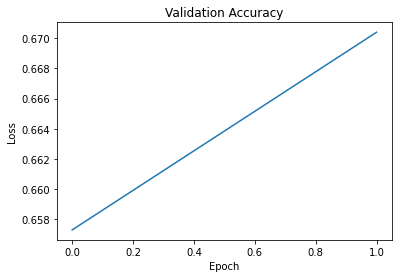

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.Tanh())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
model1ExecutionTimeTanhSGD, model1ComplexityTanhSGD, model1ValidationLossTanhSGD, model1AccuracyTanhSGD = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="Tanh-SGD")

### Avec activation = nn.ReLU

In [10]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.ReLU())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
model1ExecutionTimeTanhReLuAdam, model1ComplexityTanhReLuAdam, model1ValidationLossTanhReLuAdam, model1AccuracyTanhReLuAdam = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="ReLU-Adam")

KeyboardInterrupt: 

In [ ]:
# Définir le modèle, la fonction de coût, et l'optimiseur
model = LinearMultiClass(in_size=784, out_size=10, hidden_layers=[256, 128], activation=nn.ReLU())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=1e-5)

# Entraîner le modèle
model1ExecutionTimeTanhReLuSGD, model1ComplexityTanhReLuSGD, model1ValidationLossTanhReLuSGD, model1AccuracyTanhReLuSGD = train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="ReLU-SGD")

### Comparaison entre l'activation (Tanh & ReLU)

La fonction d'activation Tanh (hyperbolique tangente) est une fonction de transfert sigmoid qui convertit une entrée linéaire en une sortie centrée autour de zéro dans l'intervalle [-1, 1]. Elle est souvent utilisée dans les réseaux de neurones de couches cachées pour normaliser les sorties des neurones.

La fonction d'activation ReLU (rectifiée linéaire) est une fonction de transfert non linéaire qui convertit toutes les entrées négatives en zéro. Il est utilisé pour résoudre le problème de décès du neurone, qui est un phénomène où les poids des neurones peuvent devenir négatifs et rester coincés à zéro.

En général, ReLU est considéré comme étant plus rapide et plus efficace pour les modèles de réseaux de neurones en raison de sa simplicité et de la vitesse de convergence plus rapide qu'il offre comparé à Tanh. Cependant, ReLU peut aussi causer des problèmes de saturation des neurones, où de nombreux neurones peuvent devenir saturés et ne pas produire de sortie. Cela peut rendre difficile la convergence du modèle. Tanh peut éviter ce problème mais il peut être plus lent à converger.

En fin de compte, le choix de la fonction d'activation dépend du modèle et des données sur lesquels vous travaillez et des performances que vous recherchez.

In [ ]:
print ("Model Linear Multi Class With Tanh (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhAdam,"\n\tComplexité:", model1ComplexityTanhAdam, "\n\tValidation Loss:", model1ValidationLossTanhAdam, "\n\tAccurancy:", model1AccuracyTanhAdam, "] \n")
print ("Model Linear Multi Class With Tanh (SGD): [\n\tTemps d'exécution:", model1ExecutionTimeTanhSGD,"\n\tComplexité:", model1ComplexityTanhSGD, "\n\tValidation Loss:", model1ValidationLossTanhSGD, "\n\tAccurancy:", model1AccuracyTanhSGD, "] \n")

if model1ValidationLossTanhAdam <= model1ValidationLossTanhSGD:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (SGD) est le plus performant !\n___________________________________________________\n")

In [ ]:
print ("Model Linear Multi Class With ReLU (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuAdam, "\n\tComplexité:", model1ComplexityTanhReLuAdam, "\n\tValidation Loss:", model1ValidationLossTanhReLuAdam, "\n\tAccurancy:", model1AccuracyTanhReLuAdam, "] \n")
print ("Model Linear Multi Class With ReLU (SGD): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuSGD, "\n\tComplexité:", model1ComplexityTanhReLuSGD, "\n\tValidation Loss:", model1ValidationLossTanhReLuSGD, "\n\tAccurancy:", model1AccuracyTanhReLuSGD, "] \n")

if model1ValidationLossTanhReLuAdam <= model1ValidationLossTanhReLuSGD:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (SGD) est le plus performant !\n___________________________________________________\n")

In [ ]:
print ("Model Linear Multi Class With Tanh (SGD): [\n\tTemps d'exécution:", model1ExecutionTimeTanhSGD,"\n\tComplexité:", model1ComplexityTanhSGD, "\n\tValidation Loss:", model1ValidationLossTanhSGD, "\n\tAccurancy:", model1AccuracyTanhSGD, "] \n")
print ("Model Linear Multi Class With ReLU (SGD): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuSGD, "\n\tComplexité:", model1ComplexityTanhReLuSGD, "\n\tValidation Loss:", model1ValidationLossTanhReLuSGD, "\n\tAccurancy:", model1AccuracyTanhReLuSGD, "] \n")

if model1ValidationLossTanhSGD <= model1ValidationLossTanhReLuSGD:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (SGD) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (SGD) est le plus performant !\n___________________________________________________\n")

In [ ]:
print ("Model Linear Multi Class With Tanh (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhAdam,"\n\tComplexité:", model1ComplexityTanhAdam, "\n\tValidation Loss:", model1ValidationLossTanhAdam, "\n\tAccurancy:", model1AccuracyTanhAdam, "] \n")
print ("Model Linear Multi Class With ReLU (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuAdam, "\n\tComplexité:", model1ComplexityTanhReLuAdam, "\n\tValidation Loss:", model1ValidationLossTanhReLuAdam, "\n\tAccurancy:", model1AccuracyTanhReLuAdam, "] \n")

if model1ValidationLossTanhAdam <= model1ValidationLossTanhReLuAdam:
    print("Donc nous pouvons conclure que l'usage de la fonction d'entrainement en utilisant l'activation <Tanh> avec l'optimiseur Adam est bien plus efficace que l'activation <ReLU> avec l'optimiseur Adam, car :")
    print("___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("Donc nous pouvons conclure que l'usage de la fonction d'entrainement en utilisant l'activation <ReLU> avec l'optimiseur Adam est bien plus efficace que l'activation <Tanh> avec l'optimiseur Adam, car :")
    print("___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")

### Construction d'un histogramme avec les données du modèle

In [ ]:
summary = SummaryWriter(f"{TB_PATH}/{model.name}-historigramm")
addWeightsHisto(summary, model, epoch)

# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir {TB_PATH}/{model.name}-historigramm

### Pénalisation des couches
Une première technique pour éviter le sur-apprentissage est de régulariser chaque couche par une pénalisation sur les poids, i.e. de favoriser des poids faibles. On parle de pénalisation L1 lorsque la pénalité est de la forme $\|W\|_1$ et L2 lorsque la norme L2 est utilisée : $\|W\|_2^2$. En pratique, cela consiste à rajouter à la fonction de coût globale du réseau un terme en $\lambda Pen(W)$ pour les paramètres de chaque couche que l'on veut régulariser.

#### Pour la norme L2 de 10^-5

In [ ]:
print("__________________LA NORME L2 DE 10^−5 (Adam)__________________")
weight_decay = 10e-5
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-Adam-10e-5")

In [ ]:
print("__________________LA NORME L2 DE 10^−5 (SGD)__________________")
weight_decay = 10e-5
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-SGD-10e-5")

#### Pour la norme L2 de 10^-4

In [ ]:
print("\n__________________LA NORME L2 DE 10^-4 (Adam)__________________")
weight_decay = 10e-4
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-Adam-10e-4")

In [ ]:
print("\n__________________LA NORME L2 DE 10^-4 (SGD)__________________")
weight_decay = 10e-4
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-SGD-10e-4")

#### Pour la norme L2 de 10^-3

In [ ]:
print("\n__________________LA NORME L2 DE 10^-3 (Adam)__________________")
weight_decay = 10e-3
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-Adam-10e-3")

In [ ]:
print("\n__________________LA NORME L2 DE 10^-3 (SGD)__________________")
weight_decay = 10e-3
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-SGD-10e-3")

#### Pour la norme L2 de 0

In [ ]:
print("\n__________________LA NORME L2 DE 0 (Adam)__________________")
weight_decay = 0
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-Adam-10e-0")

In [ ]:
print("\n__________________LA NORME L2 DE 0 (SGD)__________________")
weight_decay = 0
model = LinearMultiClass(in_size, out_size, hidden_layers, activation=nn.Tanh())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=weight_decay)
train(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="L2-SGD-10e-0")

## Modèle LinearMultiClassWithDropout

Une autre technique très utilisée est le <a href=https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html> **Dropout** </a>. L’idée du Dropout est proche du moyennage de modèle : en entraînant k modèles de manière indépendante, on réduit la variance du modèle. Entraîner k modèles présente un surcoût non négligeable, et l’intérêt du Dropout est de réduire la complexité mémoire/temps de calcul. Le Dropout consiste à chaque itération à *geler* certains neurones aléatoirement dans le réseau en fixant leur sortie à zéro. Cela a pour conséquence de rendre plus robuste le réseau.

In [ ]:
dropout_rate = 0.5
model = LinearMultiClassWithDropout(in_size, out_size, hidden_layers, dropout_rate)

# Define our loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model Dropout
model2ExecutionTimeAdam, model2ComplexityAdam, model2ValidationLossAdam, model2AccuracyAdam = train_dropout(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, dropout_rate=dropout_rate, typeTrain="Dropout-Adam")

In [ ]:
dropout_rate = 0.5
model = LinearMultiClassWithDropout(in_size, out_size, hidden_layers, dropout_rate)

# Define our loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Train the model Dropout
model2ExecutionTimeSGD, model2ComplexitySGD, model2ValidationLossSGD, model2AccuracySGD = train_dropout(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, dropout_rate=dropout_rate, typeTrain="Dropout-SGD")

## Modèle LinearMultiClassWithBatchNorm

On sait que les données centrées réduites permettent un apprentissage plus rapide et stable d’un modèle ; bien qu’on puisse faire en sorte que les données en entrées soient centrées réduites, cela est plus délicat pour les couches internes d’un réseau de neurones. La technique de <a href=https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html> **BatchNorm**</a> consiste à ajouter une couche qui a pour but de centrer/réduire les données en utilisant une moyenne/variance glissante (en inférence) et les statistiques du batch (en
apprentissage).

In [ ]:
model = LinearMultiClassWithBatchNorm(in_size=784, out_size=10, hidden_layers=[256, 128, 64], activation=nn.Softmax())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model3ExecutionTimeAdam, model3ComplexityAdam, model3ValidationLossAdam, model3AccuracyAdam = train_batchnorm(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="BatchNorm-Adam")

In [ ]:
model = LinearMultiClassWithBatchNorm(in_size=784, out_size=10, hidden_layers=[256, 128, 64], activation=nn.Softmax())
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
model3ExecutionTimeSGD, model3ComplexitySGD, model3ValidationLossSGD, model3AccuracySGD = train_batchnorm(model, train_loader, validation_loader, loss_fn, optimizer, epochs=100, typeTrain="BatchNorm-SGD")

# Fonction de comparaison des modèles 

Cette fonction renvoie maintenant des informations détaillées sur les deux modèles, y compris la perte, la précision, la complexité en termes de nombre de paramètres et le temps d'évaluation sur les données de validation. 

Pour comparer les performances d'un modèle sur des données de validation, il est plus pratique de comparer les moyennes des pertes de validation (validation_loss) calculées sur l'ensemble des données de validation pour chaque époque.

<span style="color: red;">N.B.</span> <span style="font-style: italic;">L'accuracy est un métrique couramment utilisé pour évaluer la performance d'un modèle de classification. C'est la proportion de prédictions correctes que le modèle fait par rapport au nombre total de prédictions. L'accuracy est généralement exprimée en pourcentage et peut être calculée en comparant les étiquettes prévues par le modèle avec les étiquettes réelles. Plus l'accuracy est élevée, meilleure est la performance du modèle.</span>

In [ ]:
def compare_models(executionTimeOfModel1, complexityOfModel1, validationLossOfModel1, accuracyOfModel1, executionTimeOfModel2, complexityOfModel2, validationLossOfModel2, accuracyOfModel2):
    print("Le modèle 1 a une perte de {} sur les données de validation avec une précision de {}% et une complexité de {} paramètres et un temps d'évaluation de {}s".format(validationLossOfModel1, accuracyOfModel1*100, complexityOfModel1, executionTimeOfModel1))
    print("\nLe modèle 2 a une perte de {} sur les données de validation avec une précision de {}% et une complexité de {} paramètres et un temps d'évaluation de {}s".format(validationLossOfModel2, accuracyOfModel2*100, complexityOfModel2, executionTimeOfModel2))

    if validationLossOfModel1 < validationLossOfModel2:
        print("\n\tLe modèle 1 a une perte plus faible sur les données de validation.")
        return 1
    else:
        print("\n\tLe modèle 2 a une perte plus faible sur les données de validation.")
        return 2

# Comparaison des données des modèles

## Pour : LinearMultiClass VS LinearMultiClassWithDropout

In [ ]:
resultTest1 = compare_models(model1ExecutionTimeTanhAdam, model1ComplexityTanhAdam, model1ValidationLossTanhAdam, model1AccuracyTanhAdam, model2ExecutionTimeAdam, model2ComplexityAdam, model2ValidationLossAdam, model2AccuracyAdam)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClassWithDropout (Adam) est le plus performant !\n___________________________________________________\n")

In [ ]:
resultTest1 = compare_models(model1ExecutionTimeTanhSGD, model1ComplexityTanhSGD, model1ValidationLossTanhSGD, model1AccuracyTanhSGD, model2ExecutionTimeSGD, model2ComplexitySGD, model2ValidationLossSGD, model2AccuracySGD)

if resultTest1 == 1:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass (SGD) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClassWithDropout (SGD) est le plus performant !\n___________________________________________________\n")

## Pour : LinearMultiClass VS LinearMultiClassWithBatchNorm

In [ ]:
resultTest2 = compare_models(model1ExecutionTimeTanhAdam, model1ComplexityTanhAdam, model1ValidationLossTanhAdam, model1AccuracyTanhAdam, model3ExecutionTimeAdam, model3ComplexityAdam, model3ValidationLossAdam, model3AccuracyAdam)

if resultTest2 == 1:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClassWithBatchNorm (Adam) est le plus performant !\n___________________________________________________\n")

In [ ]:
resultTest2 = compare_models(model1ExecutionTimeTanhSGD, model1ComplexityTanhSGD, model1ValidationLossTanhSGD, model1AccuracyTanhSGD, model3ExecutionTimeSGD, model3ComplexitySGD, model3ValidationLossSGD, model3AccuracySGD)

if resultTest2 == 1:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass (SGD) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClassWithBatchNorm (SGD) est le plus performant !\n___________________________________________________\n")

## Pour : LinearMultiClassWithDropout VS LinearMultiClassWithBatchNorm

In [ ]:
resultTest3 = compare_models(model2ExecutionTimeAdam, model2ComplexityAdam, model2ValidationLossAdam, model2AccuracyAdam, model3ExecutionTimeAdam, model3ComplexityAdam, model3ValidationLossAdam, model3AccuracyAdam)

if resultTest3 == 1:
    print("\n________________________________________________________________\nLe Modèle LinearMultiClassWithDropout (Adam) est le plus performant !\n________________________________________________________________\n")
else:
    print("\n________________________________________________________________\nLe Modèle LinearMultiClassWithBatchNorm (Adam) est le plus performant !\n________________________________________________________________\n")

In [ ]:
resultTest3 = compare_models(model2ExecutionTimeSGD, model2ComplexitySGD, model2ValidationLossSGD, model2AccuracySGD, model3ExecutionTimeSGD, model3ComplexitySGD, model3ValidationLossSGD, model3AccuracySGD)

if resultTest3 == 1:
    print("\n________________________________________________________________\nLe Modèle LinearMultiClassWithDropout (SGD) est le plus performant !\n________________________________________________________________\n")
else:
    print("\n________________________________________________________________\nLe Modèle LinearMultiClassWithBatchNorm (SGD) est le plus performant !\n________________________________________________________________\n")

# Conclusion
<span style="font-style: italic;"> Nous pouvons donc conclure que le modèle <span style="color:green;">LinearMultiClass</span> est le plus performant des trois (3) modèles que nous avons eu à étudier avec nos jeux de données. En deuxième position <span style="color:yellow;">LinearMultiClassWithBatchNorm</span> et enfin <span style="color:red;">LinearMultiClassWithDropout</span></span>

In [ ]:
print ("Model Linear Multi Class With Tanh (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhAdam,"\n\tComplexité:", model1ComplexityTanhAdam, "\n\tValidation Loss:", model1ValidationLossTanhAdam, "\n\tAccurancy:", model1AccuracyTanhAdam, "] \n")
print ("Model Linear Multi Class With ReLU (Adam): [\n\tTemps d'exécution:", model1ExecutionTimeTanhReLuAdam, "\n\tComplexité:", model1ComplexityTanhReLuAdam, "\n\tValidation Loss:", model1ValidationLossTanhReLuAdam, "\n\tAccurancy:", model1AccuracyTanhReLuAdam, "] \n")

if model1ValidationLossTanhAdam <= model1ValidationLossTanhReLuAdam:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec Tanh utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")
else:
    print("\n___________________________________________________\nLe Modèle LinearMultiClass avec ReLU utilisant l'optimiseur (Adam) est le plus performant !\n___________________________________________________\n")